In [1]:
from makiflow.layers import *
from makiflow.models.segmentation.segmentator import Segmentator
from makiflow.augmentation import AffineAugment, ElasticAugment, ImageCutter, Data
from makiflow.save_recover import Builder
from makiflow.trainers import SegmentatorTrainer
from makiflow.metrics import categorical_dice_coeff, confusion_mat
import makiflow as mf

import tensorflow as tf
import numpy as np
import glob
import cv2
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.utils import shuffle
from scipy.ndimage import gaussian_filter

In [2]:
def load_data(path_to_data='../dataset/mask'):
    Xtrain = []
    Ytrain = []

    masks = glob.glob(f'{path_to_data}/*.bmp')
    for mask_name in tqdm(masks):
        img = cv2.imread(mask_name.replace('mask', 'imgs'))
        mask = cv2.imread(mask_name)
        Xtrain.append(img)
        Ytrain.append(mask)
        
    return Xtrain, Ytrain

In [54]:
images, labels = load_data()

100%|██████████| 100/100 [00:00<00:00, 320.75it/s]


In [55]:
rare_images = []
rare_labels = []

for i, (img, lbl) in enumerate(zip(images, labels)):
    u = np.unique(lbl)
    if 40 in u or 70 in u or 80 in u:
        rare_images.append(img)
        rare_labels.append(lbl)

images = rare_images
labels = rare_labels

Xtest = []
Ytest = []
Xtrain = []
Ytrain = []

for i, label in enumerate(labels):
    uniq = np.unique(label)
    if i in [7, 11, 75, 99]:
        Xtest.append(images[i])
        Ytest.append(label)
    else:
        Xtrain.append(images[i])
        Ytrain.append(label)

In [56]:
# Xtrain, Ytrain, _ = ImageCutter.image_and_mask_cutter(Xtrain, Ytrain, 384, 384, 128, 128, 0.005)
Xtest, Ytest, _ = ImageCutter.image_and_mask_cutter(Xtest, Ytest, 384, 384, 50, 50, 0.05)

In [57]:
len(Ytest)

314

In [58]:
Xtest = np.asarray(Xtest).astype(np.float32) / 255
Xtest = [i for i in Xtest]
Ytest = np.asarray(Ytest).astype(np.uint8) // 10
Ytest = [i for i in Ytest]

In [59]:
Ytest = [cv2.cvtColor(item, cv2.COLOR_BGR2GRAY) for item in Ytest]

In [60]:
mf.set_main_gpu(1)
model = Builder.segmentator_from_json('unetMobileNet/model.json')
model.set_session(tf.Session())
model.load_weights('clahe/Experiment with only rare images/MakiSegmentator_gamma=4.0_lr=0.001_bsz=16/last_weights/weights.ckpt')

Model is restored!
INFO:tensorflow:Restoring parameters from clahe/Experiment with only rare images/MakiSegmentator_gamma=4.0_lr=0.001_bsz=16/last_weights/weights.ckpt
Weights are loaded.


In [10]:
batch_sz = 16

In [23]:
n_batches = len(Xtrain[:250]) // batch_sz
labels = []
predictions = []
for i in range(n_batches):
    labels += Ytrain[i * batch_sz: (i+1) * batch_sz]
    predictions += [model.predict(Xtrain[i * batch_sz: (i+1) * batch_sz])]

In [61]:
n_batches = len(Xtest) // batch_sz
labels = []
predictions = []
for i in range(n_batches):
    labels += Ytest[i * batch_sz: (i+1) * batch_sz]
    predictions += [model.predict(Xtest[i * batch_sz: (i+1) * batch_sz])]

In [62]:
predictions = np.vstack(predictions)
labels = np.asarray(labels)

In [63]:
confusion_mat(
            predictions, labels, use_argmax_p=True, to_flatten=True,
            save_path='./mat.png', dpi=175
        )

/home/rustam/anaconda3/lib/python3.6/site-packages/makiflow/metrics/metrics.py:153: RuntimeWarning: invalid value encountered in true_divide
  mat /= mat.sum(axis=0)


array([[0.93, 0.04, 0.75, 0.29,  nan, 0.46, 0.  , 0.09],
       [0.01, 0.95, 0.  , 0.02,  nan, 0.52, 1.  , 0.  ],
       [0.01, 0.  , 0.19, 0.  ,  nan, 0.  , 0.  , 0.  ],
       [0.04, 0.01, 0.03, 0.68,  nan, 0.  , 0.  , 0.02],
       [0.  , 0.  , 0.  , 0.  ,  nan, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ,  nan, 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ,  nan, 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.03, 0.01,  nan, 0.  , 0.  , 0.89]], dtype=float32)

In [64]:
u, c = np.unique(Ytest, return_counts=True)

In [65]:
print(u, c)

[0 1 2 3 4 5 8 9] [40047597   822270   879939  3691893    76568    22614    86018   674285]


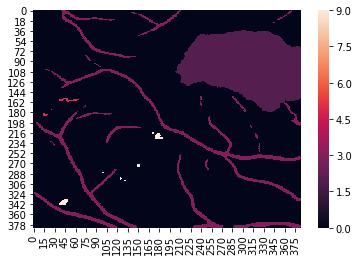

In [45]:
sns.heatmap(predictions[28].argmax(axis=2))

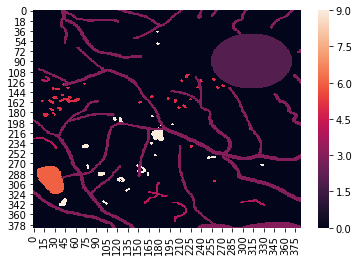

In [46]:
sns.heatmap(Ytest[28])

In [42]:
plt.imshow(use_clahe(Xtest[20]))

error: OpenCV(4.0.0) /io/opencv/modules/imgproc/src/clahe.cpp:351: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function 'apply'
